In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.offsetbox as offsetbox

import math
import random
from scipy.special import softmax

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import os
from PIL import Image
from collections import defaultdict

In [2]:
def eigen_cam(model, img, layer_name = None, label_index=None):
    """ Ce code permet est une implémentation de la méthode eigen_cam permettant de récupérer des cartes de saillance. 
        elles sont basées sur la décomposition de valeur de singulière. En gros on projette la sortie de la toute dernière couche de convolution 
        sur le premier vecteur singulier droit de l'équation. C'est la méthode avec laquelle j'ai récupéré les cartes qui sont dans ce dossier. 
        j'ai dû choisir cette méthode moins par choix que par praticité, en effet c'est une des rares à ne pas trop imposer de contraintes sur la couche 
        de sortie du réseau et donc la tâche effectuée. Puisque la couche de sortie de notre tâche d'identification est assez particulière et qu'elle n'effectue 
        pas une classification, c'était en fait la première méthode disponible. Donc, si on vous dit pendant votre soutenance que cette méthode 
        n'est pas adaptée (la SVD supposant la linéarité qui est une hypothèse baffouée en réseaux de neurones), vous pouvez répondre ça.  """
    # pour toute entrée, lui rajoute une dimension batch first si pas déjà présente:
    img = tf.convert_to_tensor(img) if not tf.is_tensor(img) else img
    img = tf.expand_dims(img, axis=0) if len(img.shape) == 3 else img # on travaille donc ici sur du (1, 224, 224, 3), càd du (batch, hauteur, largeur, canal)
    img_height, img_width = img.shape[1], img.shape[2]
    # extract the label_index of the last conv layer : 
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break
        if layer_name is None:
            raise ValueError("Aucune couche de convolution trouvée dans le modèle.")

    layer = model.get_layer(layer_name).output
    activation_model = tf.keras.Model(inputs = model.input, outputs = [model.output, layer])
    
    # 1°) Forward pass pour obtenir preds et activations de la layer
    preds, feature = activation_model(img)

    # 2°) décomposition en valeur singulière
    s, u, v = tf.linalg.svd(feature, full_matrices = True)
    vT = tf.transpose(v, [0, 1, 3, 2])

    # 3°) Calcul de la carte CAM : 
    # On multiplie d'abord s par vT : s est scalaire pour chaque composante singulière, cela revient à une multiplication element-wise
    scaled_vT = s[..., 0, None, None] * vT[..., 0, None, :]
    # Ensuite, on fait une unique multiplication matricielle avec u
    eigen_cam = tf.linalg.matmul(u[..., 0, None], scaled_vT)

    # 4°) On somme sur l'axe canal 
    eigen_cam = tf.reduce_sum(eigen_cam, axis = -1, keepdims = True)

    # 5°) Resize à l'espace (i,j) de l'image et normalisation
    eigen_cam = tf.image.resize(eigen_cam, (img_height, img_width))
    eigen_cam_min, eigen_cam_max = tf.reduce_min(eigen_cam), tf.reduce_max(eigen_cam)
    eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min)
   
    eigen_cam = tf.squeeze(eigen_cam, axis = 0)
    return eigen_cam

In [3]:
def create_autoencoder(input_latent, shape):
    input_img = tf.keras.Input(shape=shape)
    print("Shape de l input = ", input_img.shape)
    # Feature extractor (encoder)
    x = tf.keras.layers.BatchNormalization()(input_img)
    x = tf.keras.layers.Conv2D(8, kernel_size=11, padding='same', activation='relu', use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=7, activation='relu',padding='same', use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=5, activation='relu',padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu',padding='same', use_bias=False)(x)
    #x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu',padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu',padding='same', use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu',padding='same', use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu',padding='same', use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=3, activation='relu',padding='same', use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(1024, kernel_size=3, activation='relu',padding='same', use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    
    # Espace latent
    encoded = x
    latent_space_layer = tf.keras.layers.Dense(units=1*1*input_latent)(encoded)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_norm')(latent_space_layer)
    
    # Feature redear (decoder)
    x_recon = tf.keras.layers.Reshape(target_shape=(1, 1, input_latent))(latent_space_layer_norm)
    print("Shape de l x recon = ", x_recon.shape)
    x_recon = tf.keras.layers.Conv2DTranspose(1024, kernel_size=5, activation='relu', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(524, kernel_size=5, activation='relu', strides=(2, 2), padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(256, kernel_size=5, activation='relu', strides=(2, 2), padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(128, kernel_size=5, activation='relu', strides=(2, 2), padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, activation='relu', strides=(2, 2), padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, activation='relu', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(32, kernel_size=5, activation='relu', strides=(2, 2), padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(32, kernel_size=5, activation='relu', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(16, kernel_size=5, activation='relu', strides=(2, 2), padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(8, kernel_size=5, activation='relu', strides=(2, 2), padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.BatchNormalization()(x_recon)
    x_recon = tf.keras.layers.Conv2DTranspose(1, kernel_size=11, activation='sigmoid', padding='same')(x_recon)  
    x_recon = tf.keras.layers.Resizing(150, 150)(x_recon)
    print("Shape de l x recon 2 = ", x_recon.shape)
    # Full model
    model = tf.keras.Model(inputs=input_img, outputs=[x_recon])
    model.compile(optimizer='SGD', loss='mse', metrics=['mae'])

    model.summary()
    return model


In [4]:
#STIM NB LUM NORM
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        # Ajuste les dimensions
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Deuxième convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(input_latent=256):
    input_img = tf.keras.Input(shape=(150, 150, 1))
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 256, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 256, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(x)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer)
    x_recon = residual_block_recon(reshape_layer, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)

    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(150,150)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=x_recon)
    lr1 = 0.01
    lr_schedule1 = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=10000,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()
    return model

#model_res = create_resnet_autoencoder()
#--------------------------------------------------------------------------------------------------------------------------------------------

# Fairface
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(input_latent=512):
    input_img = tf.keras.Input(shape=(300, 300, 1))
    x = tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 32, 3, 2)
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 256, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 1024, 3, 2)
    x = residual_block(x, 2048, 3, 2)
    x = residual_block(x, input_latent, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(x)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    x_recon = residual_block_recon(reshape_layer, input_latent, 3, 1)
    x_recon = residual_block_recon(x_recon, 2048, 3, 2)
    x_recon = residual_block_recon(x_recon, 1024, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)
    
    x_recon = residual_block_recon(x_recon, 16, 3, 2)
    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(300,300)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=x_recon)
    lr1 = 0.01
    lr_schedule1 = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=42237,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()
    return model

#model_res = create_resnet_autoencoder()

#### Preprocessing

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)
dataset_white = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/train',
    classes=['White'],
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='input',
    color_mode='grayscale')
testset_white = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/val',
    classes=['White'],
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='input',
    color_mode='grayscale')
dataset_east_asian = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/train',
    classes=['East Asian'],
    target_size=(150, 150),
    batch_size=32,
    class_mode='input',
    color_mode='grayscale')
dataset_east_asian = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/val',
    classes=['East Asian'],
    target_size=(150, 150),
    batch_size=32,
    class_mode='input',
    color_mode='grayscale')
dataset_mixed = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/train',
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary',
    color_mode='grayscale')
dataset_mixed = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/val',
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary',
    color_mode='grayscale')

Found 12287 images belonging to 1 classes.
Found 2085 images belonging to 1 classes.
Found 12278 images belonging to 1 classes.
Found 1550 images belonging to 1 classes.
Found 24565 images belonging to 2 classes.
Found 3635 images belonging to 2 classes.


#### Affichage des premières images

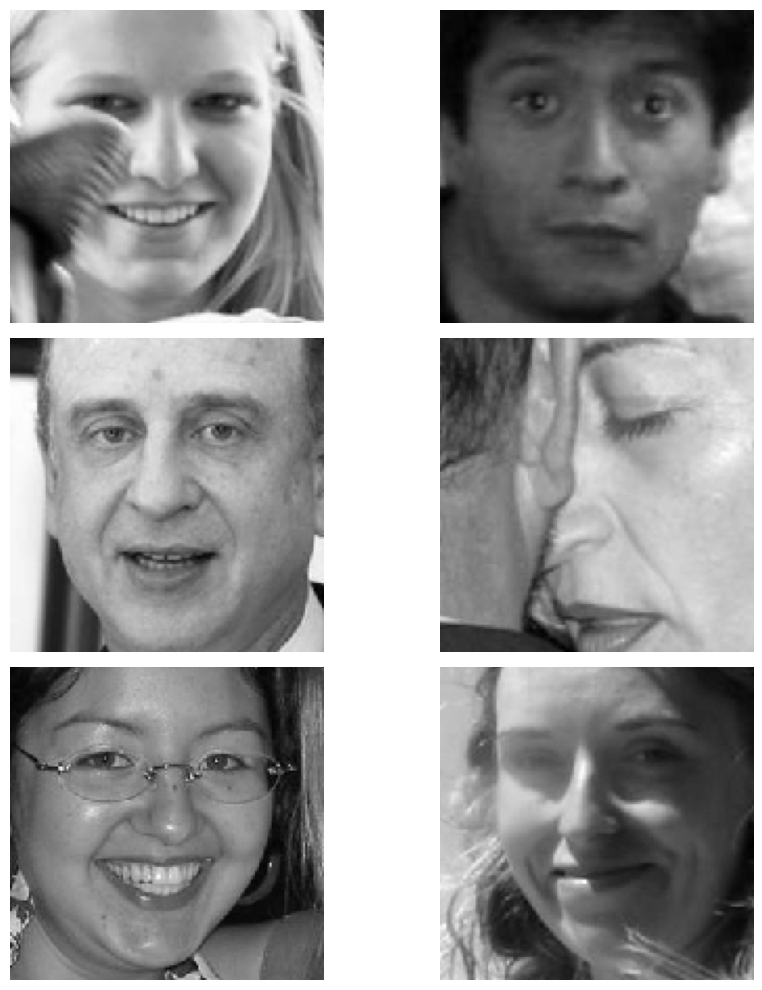

In [4]:
# Récupérer un lot d'images du générateur
batch = next(dataset_white)

# Extraire les images et les étiquettes du lot
images = batch[0]
labels = batch[1]

num_rows = 3
num_cols = 2

plt.figure(figsize=(10, 10))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].reshape((150,150)), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


#### Création modèle

In [11]:
# 1°) on définit le réseau en donnant un nom à la couche cachée dont on veut récupérer l'espace latent, par exemple : 
shape = (150, 150,1)
input_latent = 128 #nombre de dimensions de l'espace latent, celui dont on veut qu'il modélise le face space de Tim Valentine donc
model = create_autoencoder(input_latent, shape)
chekpoint_path = 'fairface_autoencoder.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=chekpoint_path,
    save_weights_only=False,
    save_frequency='epoch',
    save_best_only=True
    )

Shape de l input =  (None, 150, 150, 1)
Shape de l x recon =  (None, 1, 1, 128)
Shape de l x recon 2 =  (None, 150, 150, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 batch_normalization_21 (Bat  (None, 150, 150, 1)      4         
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 8)       968       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 75, 75, 8)        0         
 2D)                                                             
                                                                 
 batch_normalization_22 (Bat  (None, 75, 75, 8)        32        
 

#### Modèle qui récupère la reconstruction de l'image

In [17]:
# 2°) On définit un deuxième modèle dontla sortie s'arrête à la layer dont on veut récupérer la représentation, on fait ça par un : 
get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_norm').output)

#### Entraînement du modèle

In [12]:
# 3°) On entraîne le modèle : 
# cas 1, avec un autoencodeur : 
history = model.fit(x=dataset_white, epochs=1, batch_size=16, validation_data=dataset_white, callbacks=[checkpoint_callback])
# cas 2, avec un hybride : 
#history = model.fit(x_train, [x_train, y_train], validation_data=(x_test, [x_test, y_test]), epochs=30, batch_size=16)

384/384 [==============================] - 83s 199ms/step - loss: 0.0779 - mae: 0.2276 - val_loss: 0.0596 - val_mae: 0.2007


In [16]:
model2 = tf.keras.models.load_model('fairface_autoencoder.hdf5') # chargement du modèle

In [1]:
# 4°) On obtient des données que l'on met en entrée du réseau par la méthode predict:
asian_predict = 

NameError: name 'dataset_east_asian' is not defined

In [18]:
# on le plot par PCA car le nombre de dimensions de cet espace est trop grand pour être affiché, à moins d'avoir choisi input_latent = 2 plus haut
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(dataset_white)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=np.argmax(white.predict, axis=1), cmap='r', alpha=0.5)
scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=np.argmax(asian.predict, axis=1), cmap='b', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('PCA Projection of the Latent Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Note n°2 : cela présuppose d'avoir pû importer toute les données en même temps dans votre RAM, ce qui sera impossible avec le dataset VGG, donc il vaut mieux prendre fairface. Si nécessaire, pensez à importer les données avec un seul canal de couleur (donc en noir et blanc) et en (224,224) voire moins (par exemple 160,160). 

MemoryError: Unable to allocate 6.12 MiB for an array with shape (32, 224, 224, 1) and data type float32

<Figure size 800x600 with 0 Axes>